<a href="https://colab.research.google.com/github/RezuanChowdhuryRifat/Simple-GAN/blob/main/data_denoising.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [7]:
import os

import torch
import numpy as np
import torchvision
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import torchvision.datasets as datasets
import torchvision.transforms as transforms
from torch.utils.data import DataLoader, random_split
from google.colab import drive
import matplotlib.pyplot as plt
%matplotlib inline
from PIL import Image
import glob

In [2]:
drive.mount('/content/drive', force_remount=True)


Mounted at /content/drive


In [3]:

os.makedirs("dataset/Radiographic_image")

In [4]:
!cp "/content/drive/MyDrive/dataset/Radiographic Dataset-20220705T185450Z-001.zip" dataset/Radiographic_image.zip

In [ ]:
!unzip dataset/Radiographic_image.zip -d dataset/Radiographic_image


In [72]:
batch_size =32
image_size = 64
stats = (0.5, 0.5, 0.5), (0.5, 0.5, 0.5)

transform=transforms.Compose([
    transforms.Resize((64,64)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5])])


train_folder = datasets.ImageFolder(root="/content/dataset/Radiographic_image/Radiographic Dataset",transform=transform)

train_loader = torch.utils.data.DataLoader(train_folder,batch_size = batch_size, num_workers = 1, shuffle=True)


In [73]:
def denorm(img_tensors):
    return img_tensors * stats[1][0] + stats[0][0]

In [74]:
from torchvision.utils import make_grid
def show_images(images, nmax=64):
    fig, ax = plt.subplots(figsize=(8, 8))
    ax.set_xticks([]); ax.set_yticks([])
    ax.imshow(make_grid(denorm(images.detach()[:nmax]), nrow=8).permute(1, 2, 0))

def show_batch(dl, nmax=64):
    for images, _ in dl:
        show_images(images, nmax)
        break

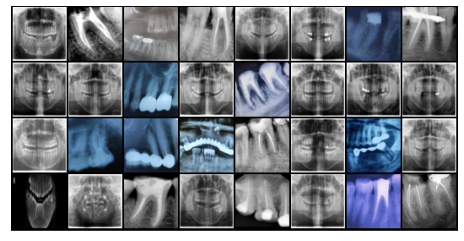

In [75]:
show_batch(train_loader)

In [76]:
def get_default_device():
    """Pick GPU if available, else CPU"""
    if torch.cuda.is_available():
        return torch.device('cuda')
    else:
        return torch.device('cpu')
    
def to_device(data, device):
    """Move tensor(s) to chosen device"""
    if isinstance(data, (list,tuple)):
        return [to_device(x, device) for x in data]
    return data.to(device, non_blocking=True)

class DeviceDataLoader():
    """Wrap a dataloader to move data to a device"""
    def __init__(self, dl, device):
        self.dl = dl
        self.device = device
        
    def __iter__(self):
        """Yield a batch of data after moving it to device"""
        for b in self.dl: 
            yield to_device(b, self.device)

    def __len__(self):
        """Number of batches"""
        return len(self.dl)

In [77]:
device = get_default_device()
device

device(type='cuda')

In [78]:
train_dl = DeviceDataLoader(train_loader, device)

In [79]:
discriminator = nn.Sequential(
    # in: 3 x 64 x 64

    nn.Conv2d(3, 64, kernel_size=4, stride=2, padding=1, bias=False),
    nn.BatchNorm2d(64),
    nn.LeakyReLU(0.2, inplace=True),
    # out: 64 x 32 x 32

    nn.Conv2d(64, 128, kernel_size=4, stride=2, padding=1, bias=False),
    nn.BatchNorm2d(128),
    nn.LeakyReLU(0.2, inplace=True),
    # out: 128 x 16 x 16

    nn.Conv2d(128, 256, kernel_size=4, stride=2, padding=1, bias=False),
    nn.BatchNorm2d(256),
    nn.LeakyReLU(0.2, inplace=True),
    # out: 256 x 8 x 8

    nn.Conv2d(256, 512, kernel_size=4, stride=2, padding=1, bias=False),
    nn.BatchNorm2d(512),
    nn.LeakyReLU(0.2, inplace=True),
    # out: 512 x 4 x 4

    nn.Conv2d(512, 1, kernel_size=4, stride=1, padding=0, bias=False),
    # out: 1 x 1 x 1

    nn.Flatten(),
    nn.Sigmoid())

In [80]:
discriminator = to_device(discriminator, device)

In [81]:
latent_size = 128

generator = nn.Sequential(
    # in: latent_size x 1 x 1

    nn.ConvTranspose2d(latent_size, 512, kernel_size=4, stride=1, padding=0, bias=False),
    nn.BatchNorm2d(512),
    nn.ReLU(True),
    # out: 512 x 4 x 4

    nn.ConvTranspose2d(512, 256, kernel_size=4, stride=2, padding=1, bias=False),
    nn.BatchNorm2d(256),
    nn.ReLU(True),
    # out: 256 x 8 x 8

    nn.ConvTranspose2d(256, 128, kernel_size=4, stride=2, padding=1, bias=False),
    nn.BatchNorm2d(128),
    nn.ReLU(True),
    # out: 128 x 16 x 16

    nn.ConvTranspose2d(128, 64, kernel_size=4, stride=2, padding=1, bias=False),
    nn.BatchNorm2d(64),
    nn.ReLU(True),
    # out: 64 x 32 x 32

    nn.ConvTranspose2d(64, 3, kernel_size=4, stride=2, padding=1, bias=False),
    nn.Tanh()
    # out: 3 x 64 x 64
)

In [82]:
generator = to_device(generator, device)

In [83]:
def train_discriminator(real_images, opt_d):
    # Clear discriminator gradients
    opt_d.zero_grad()

    # Pass real images through discriminator
    real_preds = discriminator(real_images)
    real_targets = torch.ones(real_images.size(0), 1, device=device)
    real_loss = F.binary_cross_entropy(real_preds, real_targets)
    real_score = torch.mean(real_preds).item()
    
    # Generate fake images
    latent = torch.randn(batch_size, latent_size, 1, 1, device=device)
    fake_images = generator(latent)

    # Pass fake images through discriminator
    fake_targets = torch.zeros(fake_images.size(0), 1, device=device)
    fake_preds = discriminator(fake_images)
    fake_loss = F.binary_cross_entropy(fake_preds, fake_targets)
    fake_score = torch.mean(fake_preds).item()

    # Update discriminator weights
    loss = real_loss + fake_loss
    loss.backward()
    opt_d.step()
    return loss.item(), real_score, fake_score

In [84]:
def train_generator(opt_g):
    # Clear generator gradients
    opt_g.zero_grad()
    
    # Generate fake images
    latent = torch.randn(batch_size, latent_size, 1, 1, device=device)
    fake_images = generator(latent)
    
    # Try to fool the discriminator
    preds = discriminator(fake_images)
    targets = torch.ones(batch_size, 1, device=device)
    loss = F.binary_cross_entropy(preds, targets)
    
    # Update generator weights
    loss.backward()
    opt_g.step()
    
    return loss.item()

In [85]:
from torchvision.utils import save_image
sample_dir = 'generated'
os.makedirs(sample_dir, exist_ok=True)

def save_samples(index, latent_tensors, show=True):
    fake_images = generator(latent_tensors)
    fake_fname = 'generated-images-{0:0=4d}.png'.format(index)
    save_image(denorm(fake_images), os.path.join(sample_dir, fake_fname), nrow=8)
    print('Saving', fake_fname)
    if show:
        fig, ax = plt.subplots(figsize=(8, 8))
        ax.set_xticks([]); ax.set_yticks([])
        ax.imshow(make_grid(fake_images.cpu().detach(), nrow=8).permute(1, 2, 0))

In [86]:
fixed_latent = torch.randn(64, latent_size, 1, 1, device=device)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Saving generated-images-0000.png


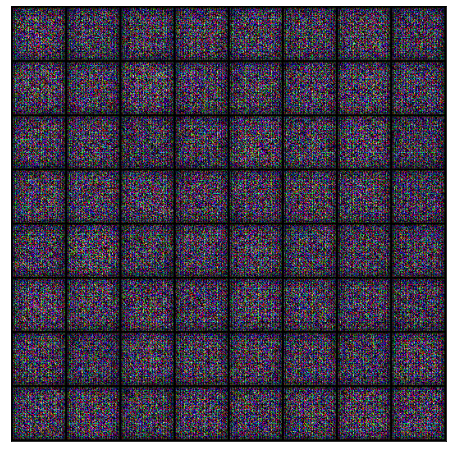

In [87]:
save_samples(0, fixed_latent)

In [88]:
from tqdm.notebook import tqdm
import torch.nn.functional as F

In [89]:
def fit(epochs, lr, start_idx=1):
    torch.cuda.empty_cache()
    
    # Losses & scores
    losses_g = []
    losses_d = []
    real_scores = []
    fake_scores = []
    
    # Create optimizers
    opt_d = torch.optim.Adam(discriminator.parameters(), lr=lr, betas=(0.5, 0.999))
    opt_g = torch.optim.Adam(generator.parameters(), lr=lr, betas=(0.5, 0.999))
    
    for epoch in range(epochs):
        for real_images, _ in tqdm(train_dl):
            # Train discriminator
            loss_d, real_score, fake_score = train_discriminator(real_images, opt_d)
            # Train generator
            loss_g = train_generator(opt_g)
            
        # Record losses & scores
        losses_g.append(loss_g)
        losses_d.append(loss_d)
        real_scores.append(real_score)
        fake_scores.append(fake_score)
        
        # Log losses & scores (last batch)
        print("Epoch [{}/{}], loss_g: {:.4f}, loss_d: {:.4f}, real_score: {:.4f}, fake_score: {:.4f}".format(
            epoch+1, epochs, loss_g, loss_d, real_score, fake_score))
    
        # Save generated images
        save_samples(epoch+start_idx, fixed_latent, show=False)
    
    return losses_g, losses_d, real_scores, fake_scores

In [102]:
lr = 0.0002
epochs = 100

In [103]:
history = fit(epochs, lr)

  0%|          | 0/20 [00:00<?, ?it/s]

Epoch [1/100], loss_g: 5.4432, loss_d: 0.0634, real_score: 0.9958, fake_score: 0.0556
Saving generated-images-0001.png


  0%|          | 0/20 [00:00<?, ?it/s]

Epoch [2/100], loss_g: 5.1377, loss_d: 0.0521, real_score: 0.9554, fake_score: 0.0046
Saving generated-images-0002.png


  0%|          | 0/20 [00:00<?, ?it/s]

Epoch [3/100], loss_g: 7.5961, loss_d: 0.0590, real_score: 0.9636, fake_score: 0.0143
Saving generated-images-0003.png


  0%|          | 0/20 [00:00<?, ?it/s]

Epoch [4/100], loss_g: 6.3770, loss_d: 0.1303, real_score: 0.9827, fake_score: 0.0972
Saving generated-images-0004.png


  0%|          | 0/20 [00:00<?, ?it/s]

Epoch [5/100], loss_g: 2.5865, loss_d: 0.2930, real_score: 0.8561, fake_score: 0.1109
Saving generated-images-0005.png


  0%|          | 0/20 [00:00<?, ?it/s]

Epoch [6/100], loss_g: 5.2508, loss_d: 0.5818, real_score: 0.9180, fake_score: 0.3240
Saving generated-images-0006.png


  0%|          | 0/20 [00:00<?, ?it/s]

Epoch [7/100], loss_g: 5.9354, loss_d: 0.2972, real_score: 0.8564, fake_score: 0.1096
Saving generated-images-0007.png


  0%|          | 0/20 [00:00<?, ?it/s]

Epoch [8/100], loss_g: 2.7239, loss_d: 0.3449, real_score: 0.9178, fake_score: 0.1764
Saving generated-images-0008.png


  0%|          | 0/20 [00:00<?, ?it/s]

Epoch [9/100], loss_g: 3.6590, loss_d: 0.5621, real_score: 0.6880, fake_score: 0.1116
Saving generated-images-0009.png


  0%|          | 0/20 [00:00<?, ?it/s]

Epoch [10/100], loss_g: 1.7685, loss_d: 0.3334, real_score: 0.8878, fake_score: 0.1682
Saving generated-images-0010.png


  0%|          | 0/20 [00:00<?, ?it/s]

Epoch [11/100], loss_g: 4.3169, loss_d: 0.6491, real_score: 0.9044, fake_score: 0.3898
Saving generated-images-0011.png


  0%|          | 0/20 [00:00<?, ?it/s]

Epoch [12/100], loss_g: 3.9739, loss_d: 0.5915, real_score: 0.9706, fake_score: 0.3900
Saving generated-images-0012.png


  0%|          | 0/20 [00:00<?, ?it/s]

Epoch [13/100], loss_g: 6.0727, loss_d: 1.3860, real_score: 0.9805, fake_score: 0.6792
Saving generated-images-0013.png


  0%|          | 0/20 [00:00<?, ?it/s]

Epoch [14/100], loss_g: 4.6577, loss_d: 0.1320, real_score: 0.9470, fake_score: 0.0608
Saving generated-images-0014.png


  0%|          | 0/20 [00:00<?, ?it/s]

Epoch [15/100], loss_g: 4.9819, loss_d: 0.6860, real_score: 0.5737, fake_score: 0.0063
Saving generated-images-0015.png


  0%|          | 0/20 [00:00<?, ?it/s]

Epoch [16/100], loss_g: 3.1673, loss_d: 0.5001, real_score: 0.9721, fake_score: 0.3377
Saving generated-images-0016.png


  0%|          | 0/20 [00:00<?, ?it/s]

Epoch [17/100], loss_g: 2.6553, loss_d: 0.3566, real_score: 0.8909, fake_score: 0.2015
Saving generated-images-0017.png


  0%|          | 0/20 [00:00<?, ?it/s]

Epoch [18/100], loss_g: 6.7270, loss_d: 0.7238, real_score: 0.9379, fake_score: 0.4384
Saving generated-images-0018.png


  0%|          | 0/20 [00:00<?, ?it/s]

Epoch [19/100], loss_g: 4.4554, loss_d: 0.4499, real_score: 0.7827, fake_score: 0.1108
Saving generated-images-0019.png


  0%|          | 0/20 [00:00<?, ?it/s]

Epoch [20/100], loss_g: 3.3758, loss_d: 0.2886, real_score: 0.9160, fake_score: 0.1542
Saving generated-images-0020.png


  0%|          | 0/20 [00:00<?, ?it/s]

Epoch [21/100], loss_g: 3.8503, loss_d: 0.2225, real_score: 0.9231, fake_score: 0.1174
Saving generated-images-0021.png


  0%|          | 0/20 [00:00<?, ?it/s]

Epoch [22/100], loss_g: 8.6374, loss_d: 0.7686, real_score: 0.9607, fake_score: 0.4435
Saving generated-images-0022.png


  0%|          | 0/20 [00:00<?, ?it/s]

Epoch [23/100], loss_g: 4.3371, loss_d: 0.3687, real_score: 0.9519, fake_score: 0.2567
Saving generated-images-0023.png


  0%|          | 0/20 [00:00<?, ?it/s]

Epoch [24/100], loss_g: 2.6562, loss_d: 0.4164, real_score: 0.7230, fake_score: 0.0227
Saving generated-images-0024.png


  0%|          | 0/20 [00:00<?, ?it/s]

Epoch [25/100], loss_g: 4.7910, loss_d: 0.1770, real_score: 0.9361, fake_score: 0.0917
Saving generated-images-0025.png


  0%|          | 0/20 [00:00<?, ?it/s]

Epoch [26/100], loss_g: 4.0627, loss_d: 0.4328, real_score: 0.7853, fake_score: 0.1278
Saving generated-images-0026.png


  0%|          | 0/20 [00:00<?, ?it/s]

Epoch [27/100], loss_g: 3.9723, loss_d: 0.3201, real_score: 0.9482, fake_score: 0.2199
Saving generated-images-0027.png


  0%|          | 0/20 [00:00<?, ?it/s]

Epoch [28/100], loss_g: 3.5844, loss_d: 0.2434, real_score: 0.9723, fake_score: 0.1308
Saving generated-images-0028.png


  0%|          | 0/20 [00:00<?, ?it/s]

Epoch [29/100], loss_g: 3.6373, loss_d: 0.4219, real_score: 0.8055, fake_score: 0.1585
Saving generated-images-0029.png


  0%|          | 0/20 [00:00<?, ?it/s]

Epoch [30/100], loss_g: 3.2321, loss_d: 0.1442, real_score: 0.9421, fake_score: 0.0786
Saving generated-images-0030.png


  0%|          | 0/20 [00:00<?, ?it/s]

Epoch [31/100], loss_g: 5.8541, loss_d: 0.2588, real_score: 0.9839, fake_score: 0.2011
Saving generated-images-0031.png


  0%|          | 0/20 [00:00<?, ?it/s]

Epoch [32/100], loss_g: 2.5075, loss_d: 0.6951, real_score: 0.5708, fake_score: 0.0252
Saving generated-images-0032.png


  0%|          | 0/20 [00:00<?, ?it/s]

Epoch [33/100], loss_g: 5.3065, loss_d: 0.1543, real_score: 0.9417, fake_score: 0.0853
Saving generated-images-0033.png


  0%|          | 0/20 [00:00<?, ?it/s]

Epoch [34/100], loss_g: 3.1883, loss_d: 0.2513, real_score: 0.8788, fake_score: 0.1032
Saving generated-images-0034.png


  0%|          | 0/20 [00:00<?, ?it/s]

Epoch [35/100], loss_g: 5.5906, loss_d: 0.4101, real_score: 0.6928, fake_score: 0.0037
Saving generated-images-0035.png


  0%|          | 0/20 [00:00<?, ?it/s]

Epoch [36/100], loss_g: 6.1337, loss_d: 0.0893, real_score: 0.9939, fake_score: 0.0768
Saving generated-images-0036.png


  0%|          | 0/20 [00:00<?, ?it/s]

Epoch [37/100], loss_g: 1.3070, loss_d: 0.1925, real_score: 0.9089, fake_score: 0.0755
Saving generated-images-0037.png


  0%|          | 0/20 [00:00<?, ?it/s]

Epoch [38/100], loss_g: 2.3649, loss_d: 0.2150, real_score: 0.9604, fake_score: 0.1494
Saving generated-images-0038.png


  0%|          | 0/20 [00:00<?, ?it/s]

Epoch [39/100], loss_g: 6.6506, loss_d: 0.1757, real_score: 0.8956, fake_score: 0.0532
Saving generated-images-0039.png


  0%|          | 0/20 [00:00<?, ?it/s]

Epoch [40/100], loss_g: 7.9446, loss_d: 0.1776, real_score: 0.8482, fake_score: 0.0023
Saving generated-images-0040.png


  0%|          | 0/20 [00:00<?, ?it/s]

Epoch [41/100], loss_g: 2.2603, loss_d: 0.3931, real_score: 0.8491, fake_score: 0.1823
Saving generated-images-0041.png


  0%|          | 0/20 [00:00<?, ?it/s]

Epoch [42/100], loss_g: 5.3984, loss_d: 0.2414, real_score: 0.8180, fake_score: 0.0275
Saving generated-images-0042.png


  0%|          | 0/20 [00:00<?, ?it/s]

Epoch [43/100], loss_g: 2.6506, loss_d: 0.3713, real_score: 0.7558, fake_score: 0.0546
Saving generated-images-0043.png


  0%|          | 0/20 [00:00<?, ?it/s]

Epoch [44/100], loss_g: 3.6666, loss_d: 0.2579, real_score: 0.9134, fake_score: 0.1447
Saving generated-images-0044.png


  0%|          | 0/20 [00:00<?, ?it/s]

Epoch [45/100], loss_g: 3.1330, loss_d: 0.2438, real_score: 0.9133, fake_score: 0.1314
Saving generated-images-0045.png


  0%|          | 0/20 [00:00<?, ?it/s]

Epoch [46/100], loss_g: 4.6150, loss_d: 1.2290, real_score: 0.6720, fake_score: 0.4496
Saving generated-images-0046.png


  0%|          | 0/20 [00:00<?, ?it/s]

Epoch [47/100], loss_g: 7.3324, loss_d: 0.6916, real_score: 0.9660, fake_score: 0.4386
Saving generated-images-0047.png


  0%|          | 0/20 [00:00<?, ?it/s]

Epoch [48/100], loss_g: 3.9213, loss_d: 0.3181, real_score: 0.9366, fake_score: 0.1759
Saving generated-images-0048.png


  0%|          | 0/20 [00:00<?, ?it/s]

Epoch [49/100], loss_g: 4.2775, loss_d: 0.2027, real_score: 0.8944, fake_score: 0.0815
Saving generated-images-0049.png


  0%|          | 0/20 [00:00<?, ?it/s]

Epoch [50/100], loss_g: 4.0688, loss_d: 0.2456, real_score: 0.9001, fake_score: 0.0917
Saving generated-images-0050.png


  0%|          | 0/20 [00:00<?, ?it/s]

Epoch [51/100], loss_g: 5.5905, loss_d: 0.3071, real_score: 0.7977, fake_score: 0.0287
Saving generated-images-0051.png


  0%|          | 0/20 [00:00<?, ?it/s]

Epoch [52/100], loss_g: 4.9235, loss_d: 0.6889, real_score: 0.8058, fake_score: 0.2904
Saving generated-images-0052.png


  0%|          | 0/20 [00:00<?, ?it/s]

Epoch [53/100], loss_g: 3.0373, loss_d: 0.1681, real_score: 0.8935, fake_score: 0.0425
Saving generated-images-0053.png


  0%|          | 0/20 [00:00<?, ?it/s]

Epoch [54/100], loss_g: 3.5989, loss_d: 0.2532, real_score: 0.9675, fake_score: 0.1836
Saving generated-images-0054.png


  0%|          | 0/20 [00:00<?, ?it/s]

Epoch [55/100], loss_g: 4.3575, loss_d: 0.2799, real_score: 0.9144, fake_score: 0.1596
Saving generated-images-0055.png


  0%|          | 0/20 [00:00<?, ?it/s]

Epoch [56/100], loss_g: 5.0686, loss_d: 0.1974, real_score: 0.9809, fake_score: 0.1567
Saving generated-images-0056.png


  0%|          | 0/20 [00:00<?, ?it/s]

Epoch [57/100], loss_g: 4.7406, loss_d: 0.3781, real_score: 0.9663, fake_score: 0.2620
Saving generated-images-0057.png


  0%|          | 0/20 [00:00<?, ?it/s]

Epoch [58/100], loss_g: 2.1615, loss_d: 0.4226, real_score: 0.7412, fake_score: 0.0806
Saving generated-images-0058.png


  0%|          | 0/20 [00:00<?, ?it/s]

Epoch [59/100], loss_g: 6.8461, loss_d: 0.6697, real_score: 0.5933, fake_score: 0.0154
Saving generated-images-0059.png


  0%|          | 0/20 [00:00<?, ?it/s]

Epoch [60/100], loss_g: 6.2314, loss_d: 0.1471, real_score: 0.9498, fake_score: 0.0854
Saving generated-images-0060.png


  0%|          | 0/20 [00:00<?, ?it/s]

Epoch [61/100], loss_g: 4.2823, loss_d: 1.4006, real_score: 0.3073, fake_score: 0.0004
Saving generated-images-0061.png


  0%|          | 0/20 [00:00<?, ?it/s]

Epoch [62/100], loss_g: 3.4702, loss_d: 0.1485, real_score: 0.9457, fake_score: 0.0791
Saving generated-images-0062.png


  0%|          | 0/20 [00:00<?, ?it/s]

Epoch [63/100], loss_g: 5.6863, loss_d: 0.2611, real_score: 0.8823, fake_score: 0.1152
Saving generated-images-0063.png


  0%|          | 0/20 [00:00<?, ?it/s]

Epoch [64/100], loss_g: 7.6103, loss_d: 0.7961, real_score: 0.9689, fake_score: 0.4296
Saving generated-images-0064.png


  0%|          | 0/20 [00:00<?, ?it/s]

Epoch [65/100], loss_g: 3.0232, loss_d: 0.2045, real_score: 0.8805, fake_score: 0.0618
Saving generated-images-0065.png


  0%|          | 0/20 [00:00<?, ?it/s]

Epoch [66/100], loss_g: 3.4386, loss_d: 0.1177, real_score: 0.9056, fake_score: 0.0070
Saving generated-images-0066.png


  0%|          | 0/20 [00:00<?, ?it/s]

Epoch [67/100], loss_g: 4.4203, loss_d: 0.0739, real_score: 0.9686, fake_score: 0.0391
Saving generated-images-0067.png


  0%|          | 0/20 [00:00<?, ?it/s]

Epoch [68/100], loss_g: 4.8635, loss_d: 0.2758, real_score: 0.8489, fake_score: 0.0357
Saving generated-images-0068.png


  0%|          | 0/20 [00:00<?, ?it/s]

Epoch [69/100], loss_g: 5.0181, loss_d: 0.3359, real_score: 0.8475, fake_score: 0.1245
Saving generated-images-0069.png


  0%|          | 0/20 [00:00<?, ?it/s]

Epoch [70/100], loss_g: 4.0798, loss_d: 0.0512, real_score: 0.9851, fake_score: 0.0344
Saving generated-images-0070.png


  0%|          | 0/20 [00:00<?, ?it/s]

Epoch [71/100], loss_g: 4.5109, loss_d: 0.4941, real_score: 0.8702, fake_score: 0.2703
Saving generated-images-0071.png


  0%|          | 0/20 [00:00<?, ?it/s]

Epoch [72/100], loss_g: 3.9503, loss_d: 0.5911, real_score: 0.8255, fake_score: 0.2472
Saving generated-images-0072.png


  0%|          | 0/20 [00:00<?, ?it/s]

Epoch [73/100], loss_g: 3.6543, loss_d: 0.2311, real_score: 0.8458, fake_score: 0.0308
Saving generated-images-0073.png


  0%|          | 0/20 [00:00<?, ?it/s]

Epoch [74/100], loss_g: 5.1710, loss_d: 0.0934, real_score: 0.9529, fake_score: 0.0399
Saving generated-images-0074.png


  0%|          | 0/20 [00:00<?, ?it/s]

Epoch [75/100], loss_g: 6.5935, loss_d: 0.1695, real_score: 0.9710, fake_score: 0.1234
Saving generated-images-0075.png


  0%|          | 0/20 [00:00<?, ?it/s]

Epoch [76/100], loss_g: 3.0873, loss_d: 0.2520, real_score: 0.8389, fake_score: 0.0562
Saving generated-images-0076.png


  0%|          | 0/20 [00:00<?, ?it/s]

Epoch [77/100], loss_g: 7.2104, loss_d: 0.8046, real_score: 0.8354, fake_score: 0.3860
Saving generated-images-0077.png


  0%|          | 0/20 [00:00<?, ?it/s]

Epoch [78/100], loss_g: 8.1347, loss_d: 0.7244, real_score: 0.9899, fake_score: 0.4275
Saving generated-images-0078.png


  0%|          | 0/20 [00:00<?, ?it/s]

Epoch [79/100], loss_g: 3.8238, loss_d: 0.5043, real_score: 0.6516, fake_score: 0.0066
Saving generated-images-0079.png


  0%|          | 0/20 [00:00<?, ?it/s]

Epoch [80/100], loss_g: 6.1750, loss_d: 0.0209, real_score: 0.9840, fake_score: 0.0047
Saving generated-images-0080.png


  0%|          | 0/20 [00:00<?, ?it/s]

Epoch [81/100], loss_g: 3.9847, loss_d: 0.2686, real_score: 0.9650, fake_score: 0.1793
Saving generated-images-0081.png


  0%|          | 0/20 [00:00<?, ?it/s]

Epoch [82/100], loss_g: 4.3207, loss_d: 0.1625, real_score: 0.8649, fake_score: 0.0066
Saving generated-images-0082.png


  0%|          | 0/20 [00:00<?, ?it/s]

Epoch [83/100], loss_g: 5.8355, loss_d: 0.2457, real_score: 0.9966, fake_score: 0.1804
Saving generated-images-0083.png


  0%|          | 0/20 [00:00<?, ?it/s]

Epoch [84/100], loss_g: 5.0083, loss_d: 0.4068, real_score: 0.8802, fake_score: 0.2001
Saving generated-images-0084.png


  0%|          | 0/20 [00:00<?, ?it/s]

Epoch [85/100], loss_g: 3.9157, loss_d: 0.2033, real_score: 0.8643, fake_score: 0.0473
Saving generated-images-0085.png


  0%|          | 0/20 [00:00<?, ?it/s]

Epoch [86/100], loss_g: 4.4741, loss_d: 0.0717, real_score: 0.9887, fake_score: 0.0559
Saving generated-images-0086.png


  0%|          | 0/20 [00:00<?, ?it/s]

Epoch [87/100], loss_g: 3.9849, loss_d: 0.0882, real_score: 0.9841, fake_score: 0.0679
Saving generated-images-0087.png


  0%|          | 0/20 [00:00<?, ?it/s]

Epoch [88/100], loss_g: 4.6407, loss_d: 0.1994, real_score: 0.9977, fake_score: 0.1562
Saving generated-images-0088.png


  0%|          | 0/20 [00:00<?, ?it/s]

Epoch [89/100], loss_g: 5.7267, loss_d: 0.4027, real_score: 0.7604, fake_score: 0.0614
Saving generated-images-0089.png


  0%|          | 0/20 [00:00<?, ?it/s]

Epoch [90/100], loss_g: 3.3558, loss_d: 0.3723, real_score: 0.8015, fake_score: 0.0669
Saving generated-images-0090.png


  0%|          | 0/20 [00:00<?, ?it/s]

Epoch [91/100], loss_g: 2.6871, loss_d: 0.3049, real_score: 0.7748, fake_score: 0.0271
Saving generated-images-0091.png


  0%|          | 0/20 [00:00<?, ?it/s]

Epoch [92/100], loss_g: 4.5069, loss_d: 0.1235, real_score: 0.9229, fake_score: 0.0376
Saving generated-images-0092.png


  0%|          | 0/20 [00:00<?, ?it/s]

Epoch [93/100], loss_g: 7.4538, loss_d: 0.4267, real_score: 0.9946, fake_score: 0.2421
Saving generated-images-0093.png


  0%|          | 0/20 [00:00<?, ?it/s]

Epoch [94/100], loss_g: 2.5566, loss_d: 0.1681, real_score: 0.9369, fake_score: 0.0917
Saving generated-images-0094.png


  0%|          | 0/20 [00:00<?, ?it/s]

Epoch [95/100], loss_g: 3.3504, loss_d: 0.1989, real_score: 0.8534, fake_score: 0.0270
Saving generated-images-0095.png


  0%|          | 0/20 [00:00<?, ?it/s]

Epoch [96/100], loss_g: 5.7609, loss_d: 0.0713, real_score: 0.9660, fake_score: 0.0344
Saving generated-images-0096.png


  0%|          | 0/20 [00:00<?, ?it/s]

Epoch [97/100], loss_g: 8.1614, loss_d: 0.5068, real_score: 0.9938, fake_score: 0.3340
Saving generated-images-0097.png


  0%|          | 0/20 [00:00<?, ?it/s]

Epoch [98/100], loss_g: 5.8471, loss_d: 0.3870, real_score: 0.9369, fake_score: 0.2137
Saving generated-images-0098.png


  0%|          | 0/20 [00:00<?, ?it/s]

Epoch [99/100], loss_g: 4.1516, loss_d: 0.2411, real_score: 0.8391, fake_score: 0.0156
Saving generated-images-0099.png


  0%|          | 0/20 [00:00<?, ?it/s]

Epoch [100/100], loss_g: 5.2957, loss_d: 0.0233, real_score: 0.9816, fake_score: 0.0044
Saving generated-images-0100.png


In [104]:
losses_g, losses_d, real_scores, fake_scores = history

In [105]:
# Save the model checkpoints 
torch.save(generator.state_dict(), 'G.pth')
torch.save(discriminator.state_dict(), 'D.pth')

In [106]:
from IPython.display import Image

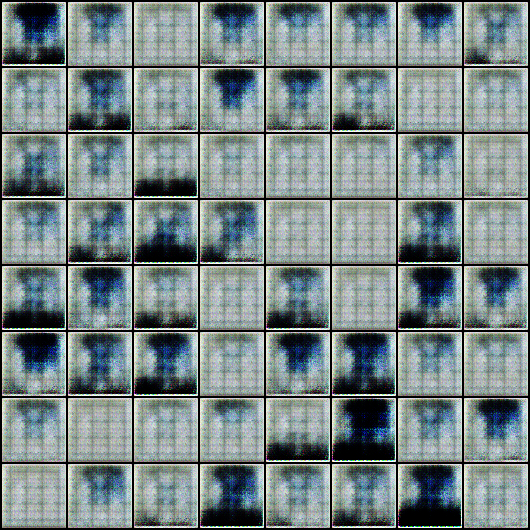

In [107]:
Image('./generated/generated-images-0001.png')

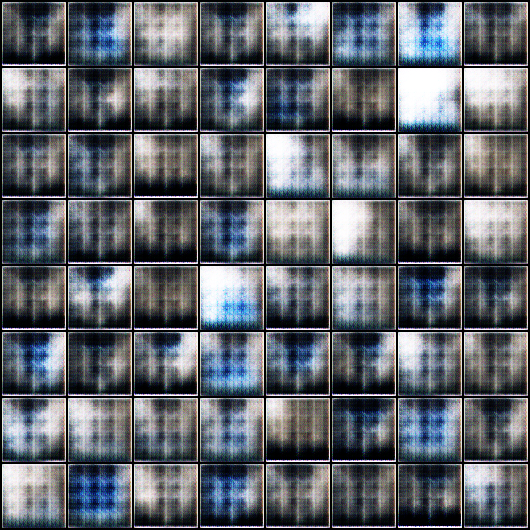

In [108]:
Image('./generated/generated-images-0005.png')

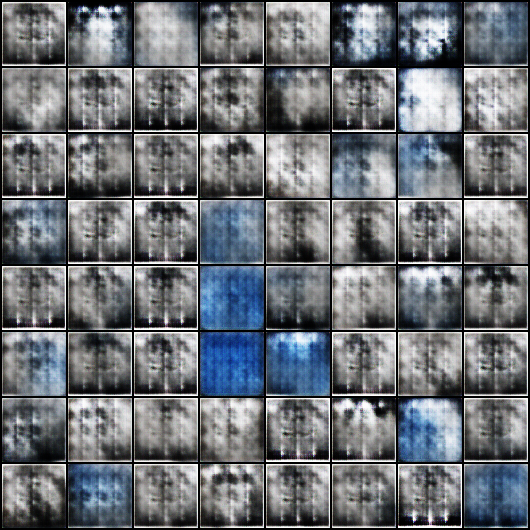

In [109]:
Image('./generated/generated-images-0025.png')

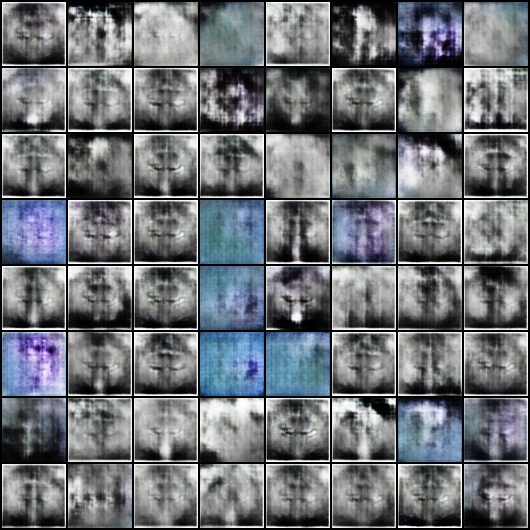

In [110]:
Image('./generated/generated-images-0050.png')

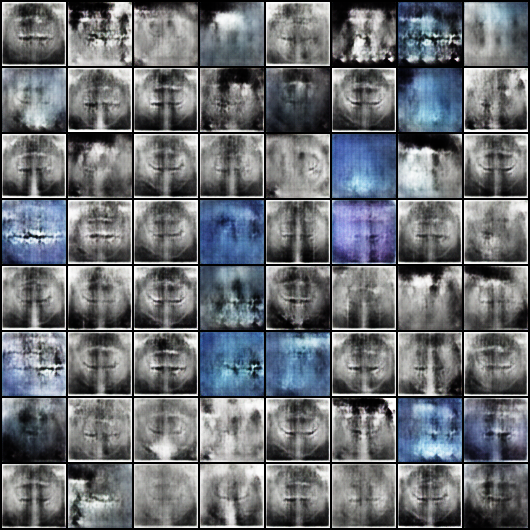

In [111]:
Image('./generated/generated-images-0080.png')

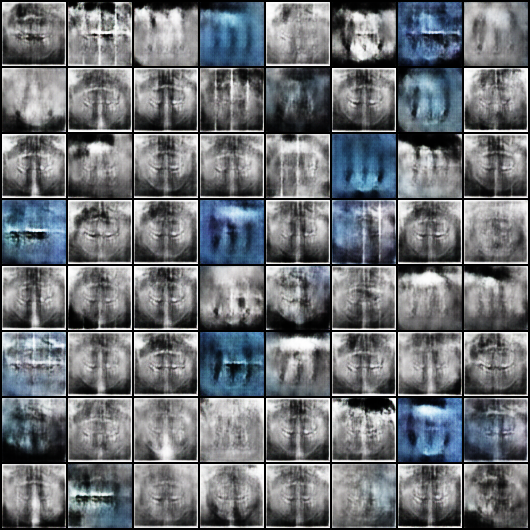

In [112]:
Image('./generated/generated-images-0100.png')

In [113]:
import cv2
import os

vid_fname = 'gans_training.avi'

files = [os.path.join(sample_dir, f) for f in os.listdir(sample_dir) if 'generated' in f]
files.sort()

out = cv2.VideoWriter(vid_fname,cv2.VideoWriter_fourcc(*'MP4V'), 1, (530,530))
[out.write(cv2.imread(fname)) for fname in files]
out.release()

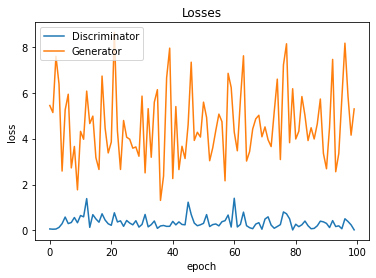

In [114]:
plt.plot(losses_d, '-')
plt.plot(losses_g, '-')
plt.xlabel('epoch')
plt.ylabel('loss')
plt.legend(['Discriminator', 'Generator'])
plt.title('Losses');

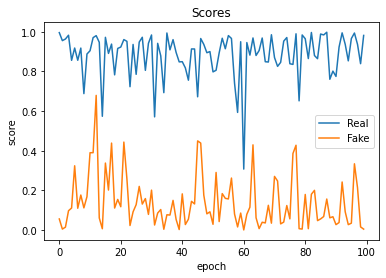

In [115]:
plt.plot(real_scores, '-')
plt.plot(fake_scores, '-')
plt.xlabel('epoch')
plt.ylabel('score')
plt.legend(['Real', 'Fake'])
plt.title('Scores');